In [10]:
import sys
import os
from dotenv import load_dotenv
import pandas as pd

# プロジェクトルートのパスを追加（quantechiaがあるディレクトリ）
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
load_dotenv()

True

In [11]:
import pandas as pd
import numpy as np
from quantechia.strategy import basestrategy, trend, risk 
from quantechia import analysis
from quantechia.data.data_fetcher import FinancialDataFetcher

from quantechia import utils
import importlib
importlib.reload(utils)
importlib.reload(basestrategy)
importlib.reload(trend)
importlib.reload(risk)
importlib.reload(analysis)

<module 'quantechia.analysis' from '/app/quantechia/analysis.py'>

In [12]:
# 株価データを取得
fetcher = FinancialDataFetcher()
tickers = ['AAPL', 'MSFT', 'GOOG']
start_date = '2023-01-01'
end_date = '2023-02-28'
historical_data = fetcher.get_historical_data("data_reader", name=tickers, data_source='stooq')
price_data = historical_data['Close']



In [13]:
equal_weight_strategy = basestrategy.EqualWeightStrategy(price_data, strategy_name="Equal Weight")
trend_following_strategy = trend.TrendFollowingStrategy(price_data, window=20, strategy_name="Trend Following")
risk_parity_strategy = risk.RiskParityStrategy(price_data, strategy_name="Risk Parity")
bl_strategy = risk.BlackLittermanStrategy(price_data, strategy_name="BL")
strategies = [equal_weight_strategy, trend_following_strategy, risk_parity_strategy,bl_strategy]


/usr/local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem doesn't have a solution with actual input parameters
Optimization failed at index 550: 'NoneType' object has no attribute 'values'
The problem doesn't have a solution with actual input parameters
Optimization failed at index 551: 'NoneType' object has no attribute 'values'


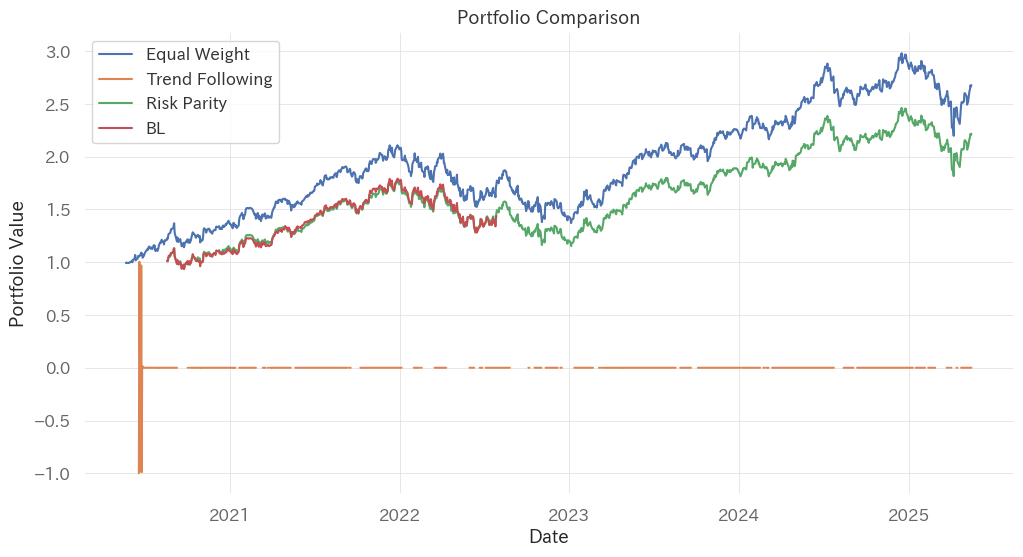

(                 sharpe_ratio  max_drawdown  winning_rate  turnover
 Equal Weight         0.898575     -0.349827      0.547049  0.000000
 Trend Following    -24.697172     -1.985148      0.123444  7.098361
 Risk Parity          0.785585     -0.347954      0.542330  0.147087
 BL                   0.616751     -1.000000      0.533165  2.554874,
             Equal Weight  Trend Following  Risk Parity        BL
 Date                                                            
 2020-05-21     -0.007430              NaN          NaN       NaN
 2020-05-22      0.004109              NaN          NaN       NaN
 2020-05-26     -0.004244              NaN          NaN       NaN
 2020-05-27      0.002097              NaN          NaN       NaN
 2020-05-28     -0.000834              NaN          NaN       NaN
 ...                  ...              ...          ...       ...
 2025-05-12      0.039813         0.023001     0.038300  0.027915
 2025-05-13      0.006031        -1.993969     0.005654  0.0

In [14]:
analysis.compare_strategies(strategies)

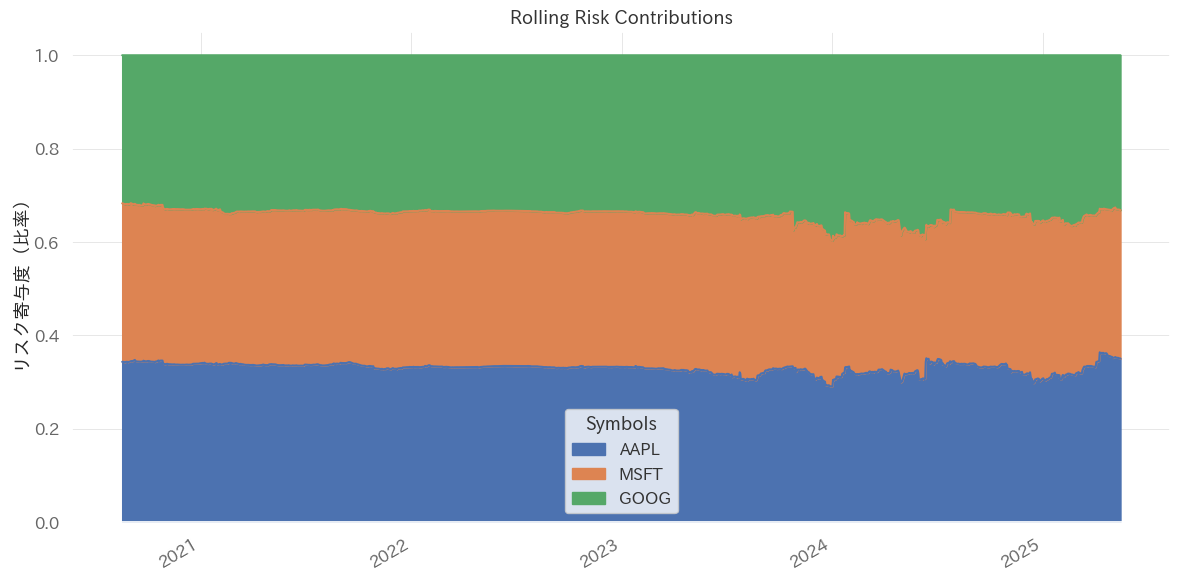

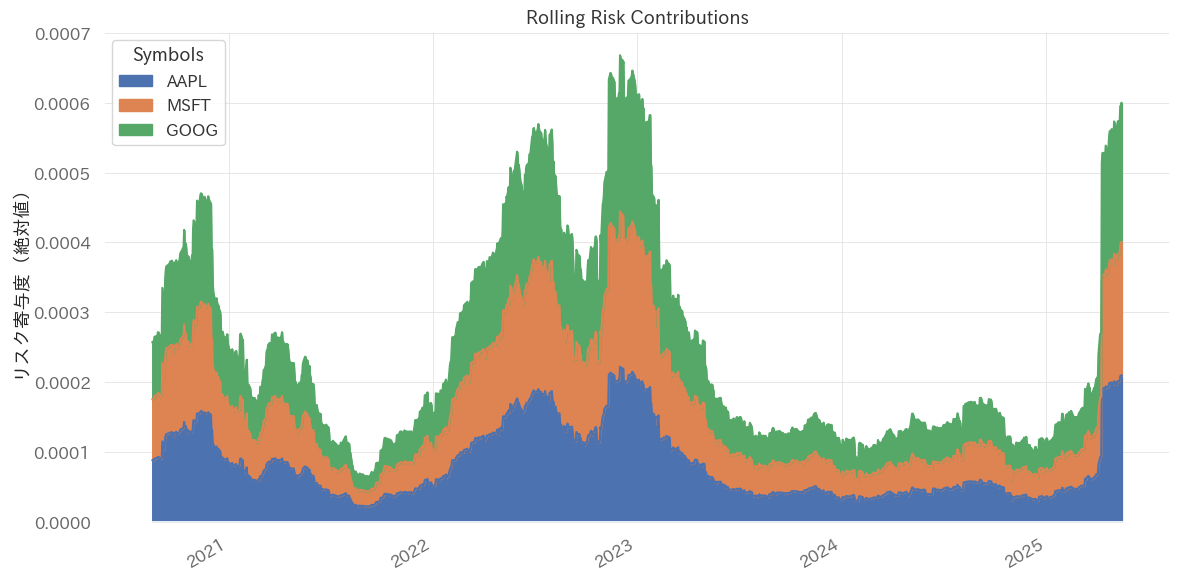

In [15]:
risk_parity_strategy.evaluate()
analyzer = analysis.RiskContribution(risk_parity_strategy.weight, risk_parity_strategy.rtn_data, lookback=60)
analyzer.calculate()

# データ取得
rc_df = analyzer.get_rc_dataframe()
rc_ratio_df = analyzer.get_ratio_dataframe()

# グラフ表示（比率）
analyzer.plot(ratio=True)
analyzer.plot(ratio=False)

In [16]:
import time
risk_parity_strategy = risk.RiskParityStrategy(price_data, strategy_name="Risk Parity")

start_time = time.time()
risk_parity_strategy.evaluate()
end_time = time.time()

elapsed = end_time - start_time
print(f"evaluate() 実行時間: {elapsed:.3f}秒")


evaluate() 実行時間: 67.076秒


In [17]:
import time
risk_parity_strategy2 = risk.RiskParityStrategyScipy(price_data, strategy_name="Risk Parity")

start_time = time.time()
risk_parity_strategy2.evaluate()
end_time = time.time()

elapsed = end_time - start_time
print(f"evaluate() 実行時間: {elapsed:.3f}秒")


evaluate() 実行時間: 6.611秒


In [18]:
from quantechia.strategy.basestrategy import RebalanceStrategy 
# 使用例
rebalance_strategy = RebalanceStrategy(price_data, rebalance_freq='ME', lookback=60, strategy_name="Rebalance Strategy")
rebalance_strategy.evaluate()

{'sharpe_ratio': np.float64(0.6969833253853982),
 'max_drawdown': np.float64(-0.3468553970743835),
 'winning_rate': 0.5316990701606086,
 'turnover': np.float64(0.37041616375216485)}

In [19]:
class RiskParityStrategyCustom(RebalanceStrategy):
    """
    A custom risk parity strategy that uses a custom optimizer for weight calculation.
    """

    def __init__(self, price_data: pd.DataFrame, rebalance_freq=None, lookback: int = 60, **kwargs):
        super().__init__(price_data, rebalance_freq=rebalance_freq, lookback=lookback, **kwargs)
    
    def calculate_current_weight(self, window_rtn):
        """
        Calculate weights using custom optimizer.
        """
        Sigma = (100*window_rtn).cov().values  # 共分散行列

        try:
            w_opt = risk.cal_risk_parity(Sigma)
        except Exception as e:
            print(f"Optimization failed at index {i}: {e}")
            w_opt = [np.nan] * len(window_rtn.columns)

        return w_opt
    
# 使用例
risk_parity_strategy_custom = RiskParityStrategyCustom(price_data, lookback=60, strategy_name="Risk Parity Custom")
risk_parity_strategy_custom.evaluate()

{'sharpe_ratio': np.float64(0.7853081484700555),
 'max_drawdown': np.float64(-0.3478649266084982),
 'winning_rate': 0.5414920368818106,
 'turnover': np.float64(0.17739513239773028)}

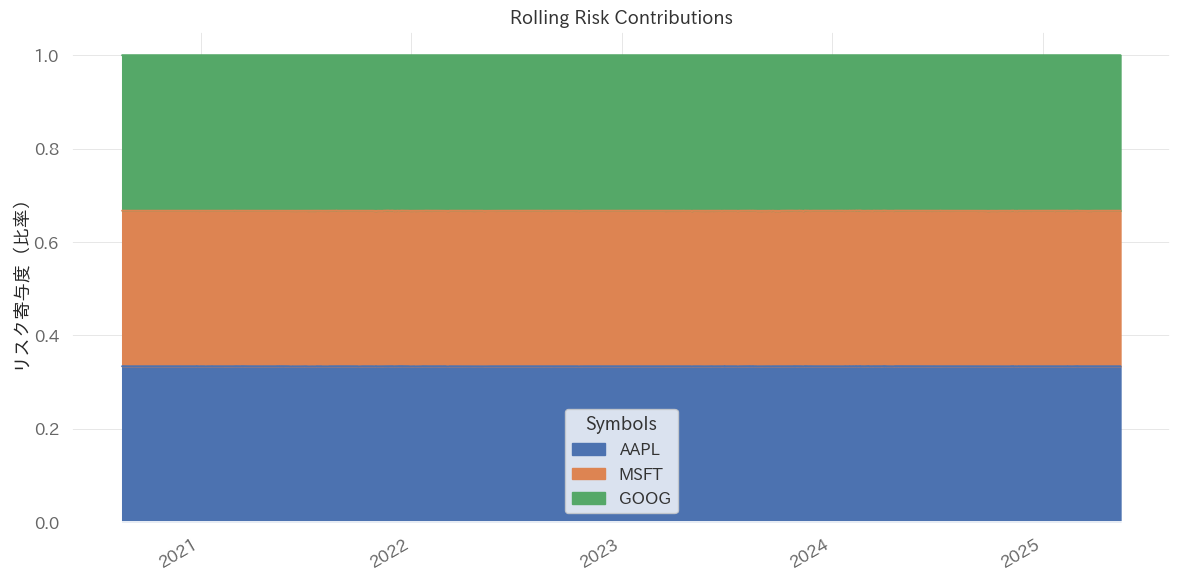

In [20]:
analyzer = analysis.RiskContribution(risk_parity_strategy_custom.weight, risk_parity_strategy_custom.rtn_data, lookback=60)
analyzer.calculate()
# データ取得
rc_df = analyzer.get_rc_dataframe()
rc_ratio_df = analyzer.get_ratio_dataframe()
# グラフ表示（比率）
analyzer.plot(ratio=True)


In [21]:
from quantechia.data.data_fetcher import FinancialDataFetcher

# 日付範囲の設定
start_date = '2021-01-01'
end_date = '2023-03-31'

# 資産のティッカー
assets = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', 'NVDA', 'JPM', 
          'V', 'PG', 'JNJ', 'UNH', 'HD', 'BAC', 'XOM', 'PFE', 'DIS', 'NFLX']

# ファクターのティッカー（ETF）
factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']

# すべてのティッカーをリストに結合
all_tickers = assets + factors

# データを取得
print("データ取得中...")
fetcher = FinancialDataFetcher()
historical_data = fetcher.get_historical_data("yahoo", tickers=all_tickers, start=start_date, end=end_date)
data = historical_data['Close']

# 欠損値を前方補間で埋める
data = data.fillna(method='ffill')

# 資産価格とファクター価格を分割
price_data = data[assets]
factor_data = data[factors]

# データをリターンに変換
returns_data = price_data.pct_change().dropna()
factor_returns = factor_data.pct_change().dropna()


データ取得中...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  23 of 23 completed
/tmp/ipykernel_82480/1069877679.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [22]:
import pandas as pd

constraints = {'Disabled': [False, False, False, False, False],
               'Factor': ['MTUM', 'QUAL', 'SIZE', 'USMV', 'VLUE'],
               'Sign': ['<=', '<=', '<=', '>=', '<='],
               'Value': [1, 0.8, 1, 0.1 , 0.9],
               'Relative Factor': ['', 'USMV', '', '', '']}

constraints_df = pd.DataFrame(constraints)

strategy = risk.FactorStrategy(
    price_data=price_data,                      # 資産の価格データ
    factors_data=factor_data,                  # ファクターの価格データ（同期間・同頻度）
    factor_constraints=constraints_df,        # 制約条件（例：MTUM <= -0.2など）
    lookback=100,  # リターンのウィンドウサイズ,
    rebalance_freq='ME',  # リバランス頻度（例：月次）
)

# 戦略のリターン計算（BaseStrategyのrunなどを呼ぶ場合）
strategy.evaluate()


{'sharpe_ratio': np.float64(0.8861896354914905),
 'max_drawdown': np.float64(-0.18093161960704918),
 'winning_rate': 0.5363636363636364,
 'turnover': np.float64(0.507689828182529)}